In [1]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version:", tf.__version__)
from tensorflow.keras.callbacks import EarlyStopping as EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Embedding
from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback
from tensorflow.keras.constraints import max_norm
from keras.utils import np_utils
import numpy as np
import random
import os
import re
import string
import glob
import sys
import io
print("GPU:", tf.test.gpu_device_name())

TensorFlow 2.x selected.
Tensorflow version: 2.0.0


Using TensorFlow backend.


GPU: /device:GPU:0


In [2]:
!git clone https://github.com/michalovsky/books_data.git

Cloning into 'books_data'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 67 (delta 16), reused 48 (delta 9), pack-reused 0
Unpacking objects: 100% (67/67), done.


In [3]:
# Read all text file paths from directory
directory1 = "books_data/kafka/"
directory2 = "books_data/shelley/"
directory3 = "books_data/defoe/"
directory4 = "books_data/plato/"

directory = directory1
file_paths = glob.glob(directory +"*.txt")    
print("Found", len(file_paths), "text files in directory:", directory)

Found 2 text files in directory: books_data/kafka/


In [4]:
# Extract text from all text files
text = ""

for file_path in file_paths:
    with open(file_path, 'r', encoding="utf-8-sig") as file:
        file_content = file.read()
        text+=file_content
print ('Length of text: {} characters'.format(len(text)))

Length of text: 573323 characters


In [7]:
# Preprocess data

punctuation_translator = str.maketrans('–—”„…«»‘’“°ſ†•✠', '               ', string.punctuation)
digits_translator = str.maketrans('', '', string.digits)
special_characters_translator = str.maketrans('ąćęłńóśźżäöüæèêéôâáà£çëîñòùúûāœï', 'acelnoszzaoueeeeoaaaeceinouuuaei', '')

# remove redundant characters and translate special characters
text = text.lower().translate(punctuation_translator).translate(digits_translator).translate(special_characters_translator)

# remove "chapter <number>" strings 
text = re.sub(r"\nchapter\s(.*)\n", "", text)

#remove extra spaces and new lines
text = ' '.join(text.split())

print ('Length of text after preprocessing: {} characters'.format(len(text)))

vocab = sorted(list(set(text)))
vocab_size = len(vocab)
print ('{} unique characters:'.format(len(vocab)))
print(vocab)

words = text.split()
print('Total words:', len(words))
print('Unique words:', len(set(words)))

Length of text after preprocessing: 547769 characters
27 unique characters:
[' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Total words: 105922
Unique words: 5612


In [8]:
# organize into sequences of words: 50 input 1 output
length = 50 + 1
sequences = list()
for i in range(length, len(words)):
	seq = words[i-length:i]
	line = ' '.join(seq)
	sequences.append(line)
print('Total Sequences: %d' % len(sequences))

Total Sequences: 105871


In [0]:
# Encode sequences of words
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sequences)
tokens = tokenizer.texts_to_sequences(sequences)

vocab_size = len(tokenizer.word_index) + 1

In [0]:
from sklearn.model_selection import train_test_split

data = np.asarray(tokens)
X, y = data[:,:-1], data[:,-1]
y = np_utils.to_categorical(y, num_classes=vocab_size)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True)

In [17]:
# define model
model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=X.shape[1]))
model.add(LSTM(100, return_sequences=True, recurrent_initializer='glorot_uniform', kernel_constraint=max_norm(3)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LSTM(100, recurrent_initializer='glorot_uniform', kernel_constraint=max_norm(3)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(vocab_size, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 50)            280650    
_________________________________________________________________
lstm_6 (LSTM)                (None, 50, 100)           60400     
_________________________________________________________________
dropout_6 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 50, 100)           400       
_________________________________________________________________
lstm_7 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 100)              

In [19]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=100)
callbacks = [ es]

batch_size = 128
epochs = 100

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=2, callbacks=callbacks)

Train on 89990 samples, validate on 15881 samples
Epoch 1/100
89990/89990 - 14s - loss: 6.6221 - accuracy: 0.0613 - val_loss: 5.7115 - val_accuracy: 0.1038
Epoch 2/100
89990/89990 - 13s - loss: 5.3563 - accuracy: 0.1218 - val_loss: 5.3204 - val_accuracy: 0.1344
Epoch 3/100
89990/89990 - 13s - loss: 4.9760 - accuracy: 0.1473 - val_loss: 5.2194 - val_accuracy: 0.1407
Epoch 4/100
89990/89990 - 13s - loss: 4.7067 - accuracy: 0.1657 - val_loss: 5.1809 - val_accuracy: 0.1524
Epoch 5/100
89990/89990 - 14s - loss: 4.4830 - accuracy: 0.1808 - val_loss: 5.1995 - val_accuracy: 0.1478
Epoch 6/100
89990/89990 - 14s - loss: 4.2779 - accuracy: 0.1961 - val_loss: 5.2580 - val_accuracy: 0.1502
Epoch 7/100
89990/89990 - 14s - loss: 4.0832 - accuracy: 0.2117 - val_loss: 5.3583 - val_accuracy: 0.1490
Epoch 8/100
89990/89990 - 13s - loss: 3.9158 - accuracy: 0.2278 - val_loss: 5.4325 - val_accuracy: 0.1478
Epoch 9/100
89990/89990 - 13s - loss: 3.7565 - accuracy: 0.2456 - val_loss: 5.5108 - val_accuracy: 0.1

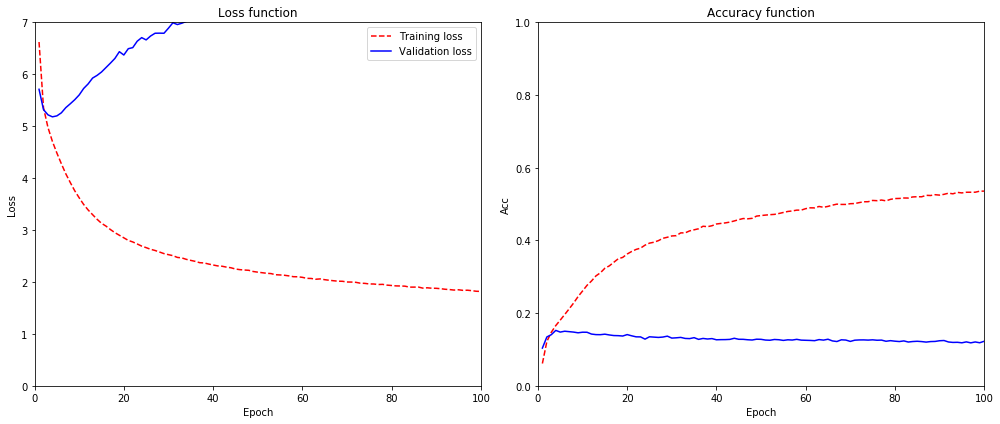

In [20]:
import matplotlib.pyplot as plt

# Make characteristics
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']

epoch_count = range(1, len(training_loss) + 1)

f = plt.figure(figsize=(14,6))

a0 = f.add_subplot(121)
a0.plot(epoch_count, training_loss, 'r--', label="Training loss")
a0.plot(epoch_count, validation_loss, 'b-', label="Validation loss")
a0.legend()
a0.set_title("Loss function")
a0.set_xlabel("Epoch")
plt.xlim(0, epochs)
a0.set_ylabel("Loss")
plt.ylim(0, np.ceil(max(training_loss)))

a1 = f.add_subplot(122)
a1.plot(epoch_count, training_acc, 'r--', label="Training acc")
a1.plot(epoch_count, validation_acc, 'b-', label="Validation acc")
a1.set_title("Accuracy function")
a1.set_xlabel("Epoch")
plt.xlim(0, epochs)
a1.set_ylabel("Acc")
plt.ylim(0, 1)
# plt.savefig(save_directory+"/characteristics.png")  

plt.tight_layout()
plt.show()

In [0]:
from keras.preprocessing.sequence import pad_sequences

# generate a sequence from a language model
def generate_seq(model, tokenizer, seq_length, seed_text, n_words):
	result = list()
	in_text = seed_text
	# generate a fixed number of words
	for _ in range(n_words):
		# encode the text as integer
		encoded = tokenizer.texts_to_sequences([in_text])[0]
		# truncate sequences to a fixed length
		encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
		# predict probabilities for each word
		yhat = model.predict_classes(encoded, verbose=0)
		# map predicted word index to word
		out_word = ''
		for word, index in tokenizer.word_index.items():
			if index == yhat:
				out_word = word
				break
		# append to input
		in_text += ' ' + out_word
		result.append(out_word)
	return ' '.join(result)

In [22]:
# select a seed text
from random import randint
seq_length = X.shape[1]
seed_text = sequences[randint(0,len(sequences))]
print(seed_text + '\n')
 
# generate new text
generated = generate_seq(model, tokenizer, 50, seed_text, 50)
print(generated)

like a kind of torture acknowledged by the court connected with the trial and which followed him around and is it likely that anyone in the bank when judging his work would take any account of his peculiar situation no one and never there were those who knew about his trial

but it was not a good choice but to explain the more than to help him and this painter was no longer needed to give him the deputy director was very happy to him with the chief clerk as he could but he had to push his elbows on the
